# Recurrent Neural Network
Télécharger les données Train.csv depuis la plateforme Zindi. Puis sur votre gauche clickez sur Files, et faite un drag and drop du fichier.

Commençons par observer les variables du dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
print(tf.__version__)

2.0.0-beta0


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


training_data_url = "https://raw.githubusercontent.com/ummisco-deep-learning/Soil_Moisture_Challenge/master/data/Train.csv"
train = pd.read_csv(training_data_url)
columns = train.keys()

print(columns)


Index(['timestamp', 'Soil humidity 1', 'Irrigation field 1', 'Soil humidity 2',
       'Irrigation field 2', 'Soil humidity 3', 'Irrigation field 3',
       'Soil humidity 4', 'Irrigation field 4', 'Air temperature (C)',
       'Air humidity (%)', 'Pressure (KPa)', 'Wind speed (Km/h)',
       'Wind gust (Km/h)', 'Wind direction (Deg)'],
      dtype='object')


In [0]:
# Let's work with np array as it might make things easier

slot1 = np.array(train["Soil humidity 1"])
slot2 = np.array(train["Soil humidity 2"])
slot3 = np.array(train["Soil humidity 3"])
slot4 = np.array(train["Soil humidity 4"])

irrigation1 = np.array(train["Irrigation field 1"])
irrigation2 = np.array(train["Irrigation field 2"])
irrigation3 = np.array(train["Irrigation field 3"])
irrigation4 = np.array(train["Irrigation field 4"])

Text(0.5, 1.0, 'Air temperature (C)')

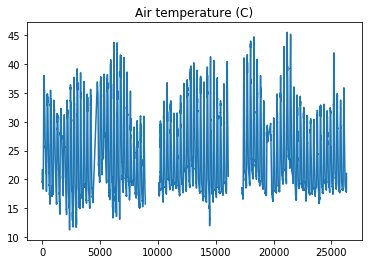

In [0]:
plt.plot(train['Air temperature (C)'])
plt.title('Air temperature (C)')

Text(0.5, 1.0, 'Air humidity (%)')

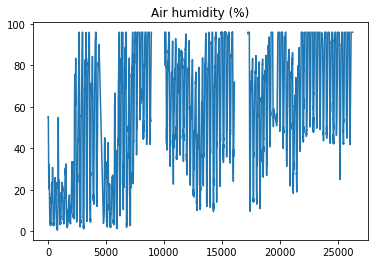

In [0]:
plt.plot(train['Air humidity (%)'])
plt.title('Air humidity (%)')

Après vérification toutes les données or irrigation,humidité du sol et date ont des NAN aux mêmes positions. 

In [5]:
mask = train['Air humidity (%)'].isna()

for i in range (len(mask)):
  if mask[i] == True:    
    break

nan_safe_idx = i  
print("First Nan appears at index {}".format(nan_safe_idx))

First Nan appears at index 8914


Concentrons nous sur les 8914 premières valeurs. On va voir s'il est possible de prédire l'humidité du sol avec toutes les variables communes aux 4 champs.

In [0]:
print(columns)

Index(['timestamp', 'Soil humidity 1', 'Irrigation field 1', 'Soil humidity 2',
       'Irrigation field 2', 'Soil humidity 3', 'Irrigation field 3',
       'Soil humidity 4', 'Irrigation field 4', 'Air temperature (C)',
       'Air humidity (%)', 'Pressure (KPa)', 'Wind speed (Km/h)',
       'Wind gust (Km/h)', 'Wind direction (Deg)'],
      dtype='object')


In [0]:
air_temp = np.expand_dims(np.array(train['Air temperature (C)'].iloc[:nan_safe_idx]),1)
air_humid = np.expand_dims(np.array(train['Air humidity (%)'].iloc[:nan_safe_idx]),1)
pressure = np.expand_dims(np.array(train['Pressure (KPa)'].iloc[:nan_safe_idx]),1)
wind_speed = np.expand_dims(np.array(train['Wind speed (Km/h)'].iloc[:nan_safe_idx]),1)
wind_gust = np.expand_dims(np.array(train['Wind gust (Km/h)'].iloc[:nan_safe_idx]),1)
wind_direction = np.expand_dims(np.array(train['Wind direction (Deg)'].iloc[:nan_safe_idx]),1)



Text(0.5, 1.0, 'Air temperature (C)')

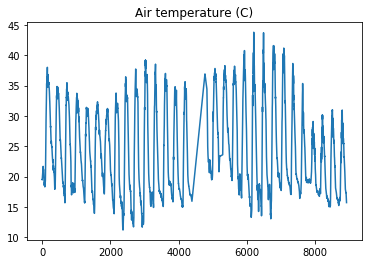

In [0]:
plt.plot(air_temp)
plt.title('Air temperature (C)')

In [71]:
data = slot1[:nan_safe_idx]
data.shape

(8914,)

In [73]:
irrigation1 = np.expand_dims(irrigation1[:nan_safe_idx],axis=-1)
features = np.concatenate([air_temp, air_humid, pressure, wind_speed, wind_gust, wind_direction, irrigation1],axis=1)
features.shape

(8914, 7)

In [0]:
# Some preprocessing for a RNN

def get_sequence(seq_size, data):
  nb_seq = len(data)//seq_size
  seq_arr = []
  for i in range(nb_seq):
    seq_arr.append(data[i*seq_size:(i+1)*seq_size])
#   seq_arr.append(data[(i+1)*seq_size:])
  return seq_arr

arr_labels = get_sequence(32, data)
arr_features  = get_sequence(32, features)


In [75]:
arr_labels = np.expand_dims(np.array(arr_labels), axis=2)
arr_features = np.array(arr_features)

arr_features.shape

(278, 32, 7)

In [0]:
train_size = int(.7 * len(arr_labels))

training_features = arr_features[:train_size]
training_labels = arr_labels[:train_size]

test_features = arr_features[train_size:]
test_labels = arr_labels[train_size:]


Les données sont en formes pour tester un RNN. Commençons avec un GRU

In [94]:
from tensorflow.keras.layers import GRU, Input

x = Input(batch_shape=(1,32,7))

h1 = GRU(32, input_shape=(), return_sequences=True, stateful=True)(x)
h2 = GRU(32, input_shape=(), return_sequences=True, stateful=True)(h1)
h3 = GRU(32, input_shape=(), return_sequences=True, stateful=True)(h2)
y = Dense(1)(h3)

model = Model(x,y)
model.compile(optimizer='adam', loss='mse')



In [98]:
%%time
history = model.fit(training_features, training_labels, epochs=1500)

Train on 194 samples
Epoch 1/1500
194/194 [==============================] - 7s 36ms/sample - loss: 3346.5818
Epoch 2/1500
194/194 [==============================] - 6s 30ms/sample - loss: 2541.2484
Epoch 3/1500
194/194 [==============================] - 6s 30ms/sample - loss: 1987.7765
Epoch 4/1500
194/194 [==============================] - 6s 29ms/sample - loss: 1537.7093
Epoch 5/1500
194/194 [==============================] - 6s 29ms/sample - loss: 1174.3370
Epoch 6/1500
194/194 [==============================] - 6s 28ms/sample - loss: 884.2633
Epoch 7/1500
194/194 [==============================] - 5s 27ms/sample - loss: 656.2929
Epoch 8/1500
194/194 [==============================] - 6s 30ms/sample - loss: 480.2898
Epoch 9/1500
194/194 [==============================] - 6s 29ms/sample - loss: 347.6339
Epoch 10/1500
194/194 [==============================] - 6s 29ms/sample - loss: 250.6019
Epoch 11/1500
194/194 [==============================] - 5s 28ms/sample - loss: 181.5460
Epoc

In [99]:
model1.evaluate(test_features, test_labels)

84/84 [==============================] - 0s 5ms/sample - loss: 193.7511


193.75109618334542

In [0]:
training_predictions = model1.predict(training_features)
test_predictions = model1.predict(test_features)

In [0]:
s0,s1,_ = training_features.shape
training_predictions = training_predictions.reshape(s0*s1)
training_labels = training_labels.reshape(s0*s1)

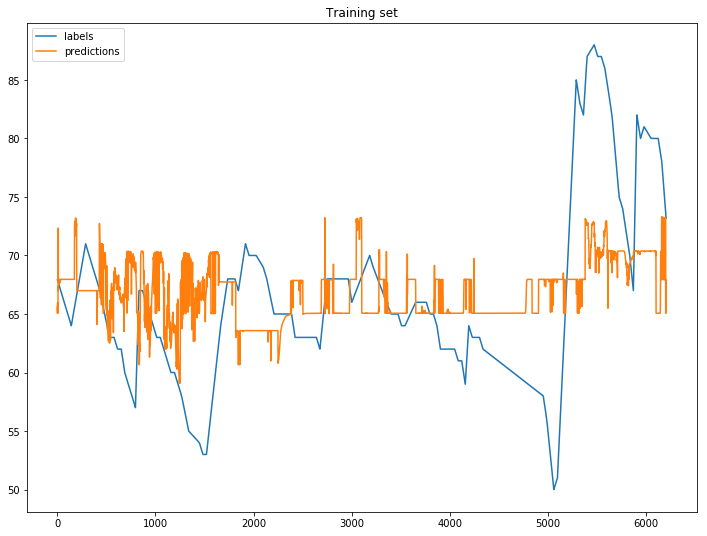

In [102]:
plt.figure(figsize=(12,9))
plt.plot(training_labels, label="labels")
plt.plot(training_predictions, label="predictions")
plt.legend()
plt.title("Training set")
plt.show()

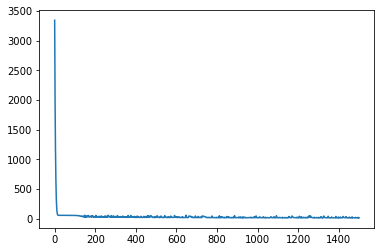

In [103]:
losses = history.history['loss']
plt.plot(losses)

In [24]:
model.predict(test_features,batch_size=len(test_features))
 

ValueError: ignored